In [1]:
# Fit Forward, 2 day gap

In [19]:
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import random

In [20]:
maindir = '/results/forcing/rivers/observations/'
origdir = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/'
def getdir(river_name):
    if river_name in ['Fraser', 'Englishman']:
        thedir = origdir
    else:
        thedir = maindir
    return (thedir)

In [21]:
def read_river(river_name, ps):
    thedir = getdir(river_name)
    river_flow = pd.read_csv(f'{thedir}/{river_name}_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    river_flow['date'] = pd.to_datetime(river_flow.drop(columns='flow'))
    river_flow.set_index('date', inplace=True)
    river_flow = river_flow.drop(columns=['year', 'month', 'day'])
    if ps == 'primary':
        river_flow = river_flow.rename(columns={'flow': 'Primary River Flow'})
    elif ps == 'secondary':
        river_flow = river_flow.rename(columns={'flow': 'Secondary River Flow'})
    return river_flow

In [22]:
def read_river_Theodosia(set_primary=False):
    if set_primary:
        nameit = 'Primary River Flow'
    else:
        nameit = 'Secondary River Flow'
    part1 = pd.read_csv(f'{maindir}/Theodosia_Scotty_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part2 = pd.read_csv(f'{maindir}/Theodosia_Bypass_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    part3 = pd.read_csv(f'{maindir}/Theodosia_Diversion_flow', header=None, sep='\s+', index_col=False,
                      names=['year', 'month', 'day', 'flow'])
    for part in [part1, part2, part3]:
        part['date'] = pd.to_datetime(part.drop(columns='flow'))
        part.set_index('date', inplace=True)
        part.drop(columns=['year', 'month', 'day'], inplace=True)
    part1 = part1.rename(columns={'flow': 'Scotty'})
    part2 = part2.rename(columns={'flow': 'Bypass'})
    part3 = part3.rename(columns={'flow': 'Diversion'})
    theodosia = (part3.merge(part2, how='inner', on='date')).merge(part1, how='inner', on='date')
    theodosia[nameit] = theodosia['Scotty'] + theodosia['Diversion'] - theodosia['Bypass']
    part3['FlowFromDiversion'] = part3.Diversion * theodosia_from_diversion_only
    theodosia = theodosia.merge(part3, how='outer', on='date', sort=True)
    theodosia[nameit] = theodosia[nameit].fillna(
        theodosia['FlowFromDiversion'])
    return theodosia

In [23]:
matching_dictionary = {'Englishman': 'Salmon_Sayward',
                      'Theodosia': 'Clowhom_ClowhomLake',
                      'RobertsCreek': 'Englishman',
                      'Salmon_Sayward': 'Englishman',
                      'Squamish_Brackendale': 'Homathko_Mouth',
                      'SanJuan_PortRenfrew': 'Englishman',
                      'Nisqually_McKenna': 'Snohomish_Monroe',
                      'Snohomish_Monroe': 'Skagit_MountVernon',
                      'Skagit_MountVernon': 'Snohomish_Monroe',
                      'Homathko_Mouth': 'Squamish_Brackendale',
                      'Nicomekl_Langley': 'RobertsCreek',
                      'Greenwater_Greenwater': 'Snohomish_Monroe',
                      'Clowhom_ClowhomLake': 'Theodosia_Diversion'}
backup_dictionary = {'SanJuan_PortRenfrew': 'RobertsCreek',
                    'Theodosia': 'Englishman'}

theodosia_from_diversion_only = 1.429 # see TheodosiaWOScotty

In [24]:
gap_length = 2

In [83]:
def estimate(primary_river, spoint, point, gap_length, ax, fittedbad, fittype, doplots=True):
    goback = 7
    bad = False
    fitlength = np.array([7, 14, 21, 28])
    ratio = np.zeros(len(fitlength))
    fitted = np.zeros(len(fitlength))
    persist = np.zeros((goback))
    linear = np.zeros((goback-1))
    cubic = np.zeros((goback-2))
    for ii in range(1, 8):
        jj = ii + gap_length - 1
        if len(primary_river.iloc[spoint-8:spoint]) != 8:
            print (len(primary_river.iloc[spoint-8:spoint]), primary_river.iloc[spoint])
        persist[ii-1] = primary_river.iloc[spoint-ii:spoint].mean()
        if ii > 1:
            b, m = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 1)
            linear[ii-2] = b + m * jj
        if ii > 2:
            b, m, c = polyfit(range(ii), primary_river.iloc[spoint-ii:spoint].values, 2)
            cubic[ii-3] = b + m * jj + c * jj**2
    if fittype == 'fit':
        useriver = matching_dictionary[river]
    elif fittype == 'backup':
        useriver = backup_dictionary[river]
    firstchoice = read_river(useriver, 'primary')
    for jj, length in enumerate(fitlength):
        for ii in range(length):
            denom = firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values
            if len(denom) == 1:
                ratio[jj] = ratio[jj] + (primary_river.iloc[spoint-ii].values /
                            firstchoice[firstchoice.index == primary_river.index[spoint-ii]].values)
            else:
                bad = True
        if not bad:
            fitted[jj] = ratio[jj]/length * firstchoice[firstchoice.index == primary_river.index[point]].values
    if bad:
        fittedbad = fittedbad + 1
    if doplots:
        ax.plot(persist)
        ax.plot(range(1, 7), linear)
        ax.plot(range(2, 7), cubic)
        if not bad:
            ax.plot(fitted)
        ax.plot(primary_river.iloc[spoint-7:spoint].values, 'o')
        ax.plot(7, primary_river.iloc[spoint].values, 'x')
        ax.plot(7+gap_length, primary_river.iloc[point].values, 's')
        ax.grid()
    return (persist, linear, cubic, fitted, bad, fittedbad)

In [26]:
def pmhalf(test, value):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt/value < 0.5 or tt/value > 2:
            bads[ii] = True
    return bads

In [27]:
def inbounds(test, maximum, minimum):
    bads = np.zeros(len(test), dtype='bool')
    for ii, tt in enumerate(test):
        if tt < minimum or tt > maximum:
            bads[ii] = True
    return bads

In [28]:
def docheck(primary_river, point, persist, linear, cubic, fitted, badfit, ax, doplots=True):
    maximum = primary_river['Primary River Flow'].max()
    minimum = primary_river['Primary River Flow'].min()
    value = primary_river.iloc[point].values
    goodness_persist = np.abs(persist - value)
    goodness_linear = np.abs(linear - value)
    goodness_cubic = np.abs(cubic - value)
    if not badfit:
        goodness_fit = np.abs(fitted - value)
        pmfitted = pmhalf(fitted, value)
        ibfitted = inbounds(fitted, maximum, minimum)
    else:
        goodness_fit = np.zeros((4))
        pmfitted = np.zeros((4))
        ibfitted = np.zeros((4))
    if doplots:
        ax.plot(goodness_persist, 'o')
        ax.plot(goodness_linear, 'o')
        ax.plot(goodness_cubic, 'o')
        if not badfit:
            ax.plot(goodness_fit, 'o')
        ax.grid()
    return (np.concatenate((goodness_persist, goodness_linear, goodness_cubic, goodness_fit)), 
            np.concatenate((pmhalf(persist, value), pmhalf(linear, value), pmhalf(cubic, value), pmfitted)),
            np.concatenate((inbounds(persist, maximum, minimum), inbounds(linear, maximum, minimum), 
                            inbounds(cubic, maximum, minimum), ibfitted)))

In [84]:
def doone(primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, fittype, doplots=True):

    point = random.randrange(len(primary_river.index))
    spoint = point - gap_length + 1
    
    if doplots:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))

        primary_river.iloc[point-10:point+1].plot(ax=axs[0], marker='s')
    else:
        axs = [0, 1, 2]

    (persist, linear, cubic, fitted, badfit, fittedbad) = estimate(
        primary_river, spoint, point, gap_length, axs[1], fittedbad, fittype, doplots)

    GG, CC, BB = docheck(primary_river, point, persist, linear, cubic, fitted, badfit, axs[2], doplots)
    accumulateG += GG
    accumulateC += CC
    accumulateB += BB
    
    
    return accumulateG, accumulateC, accumulateB, fittedbad

In [62]:
print (gap_length)

2


In [64]:
river = 'Englishman'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  913.  913.  913.  913.] [ 7.91821743  8.39621539  8.58198423  8.77106217  8.74862864  8.65689493
  8.68123343 12.35958708 13.40550008 12.8286417  12.34468564 11.70461581
 11.66124141 28.98472775 22.24037008 21.98875464 19.72919076 19.01966209
  4.90731109  5.3317436   5.62086106  5.76637892] [0.123      0.129      0.15       0.166      0.171      0.184
 0.195      0.246      0.245      0.252      0.252      0.266
 0.278      0.367      0.355      0.339      0.337      0.338
 0.07338445 0.08433735 0.09309967 0.11171961] [0.    0.    0.    0.    0.    0.    0.    0.047 0.065 0.058 0.043 0.046
 0.048 0.111 0.114 0.108 0.114 0.12  0.    0.    0.    0.   ]


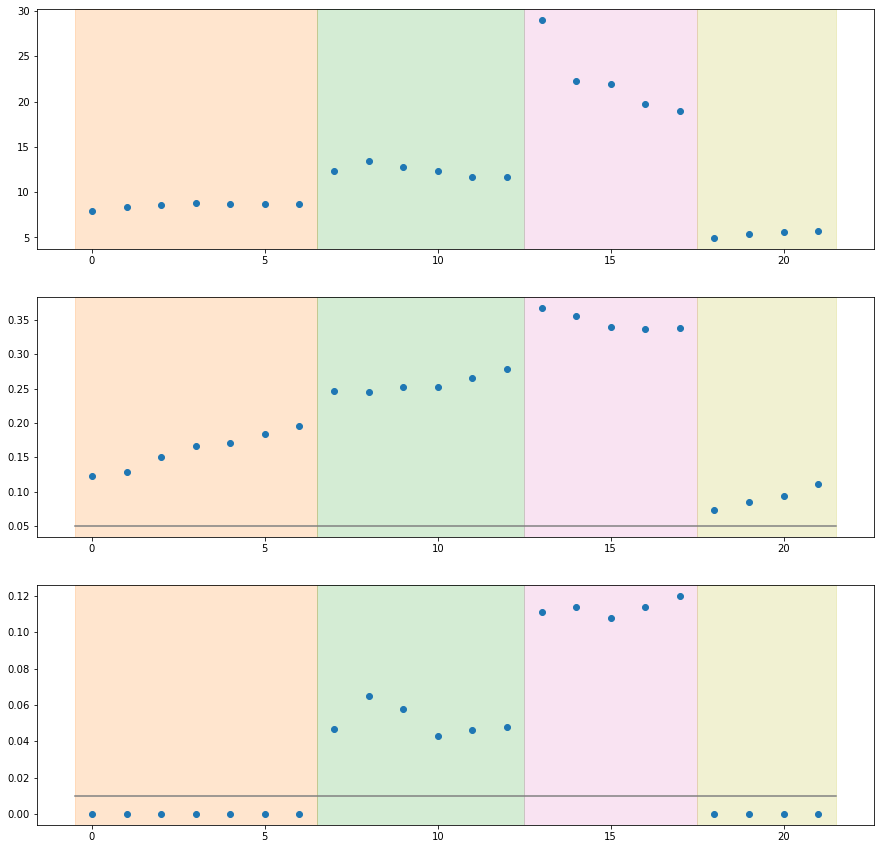

In [65]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [68]:
river = 'Homathko_Mouth'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  957.  957.  957.  957.] [ 53.21400941  59.379609    63.69695283  66.46818152  68.46364317
  70.02523711  71.54673636  71.29975773  75.79097114  76.87031165
  77.50801295  77.71329992  77.81051554 138.29692302 118.18157703
 117.31534253 114.36627454 111.27756779  40.27978953  46.62591753
  51.22402913  56.48667543] [0.031      0.041      0.049      0.052      0.051      0.051
 0.051      0.063      0.064      0.068      0.08       0.081
 0.085      0.177      0.148      0.153      0.152      0.147
 0.02403344 0.03239289 0.03239289 0.04284222] [0.         0.         0.         0.         0.         0.
 0.         0.01       0.011      0.007      0.008      0.008
 0.011      0.065      0.065      0.061      0.052      0.049
 0.00208986 0.00104493 0.00208986 0.00208986]


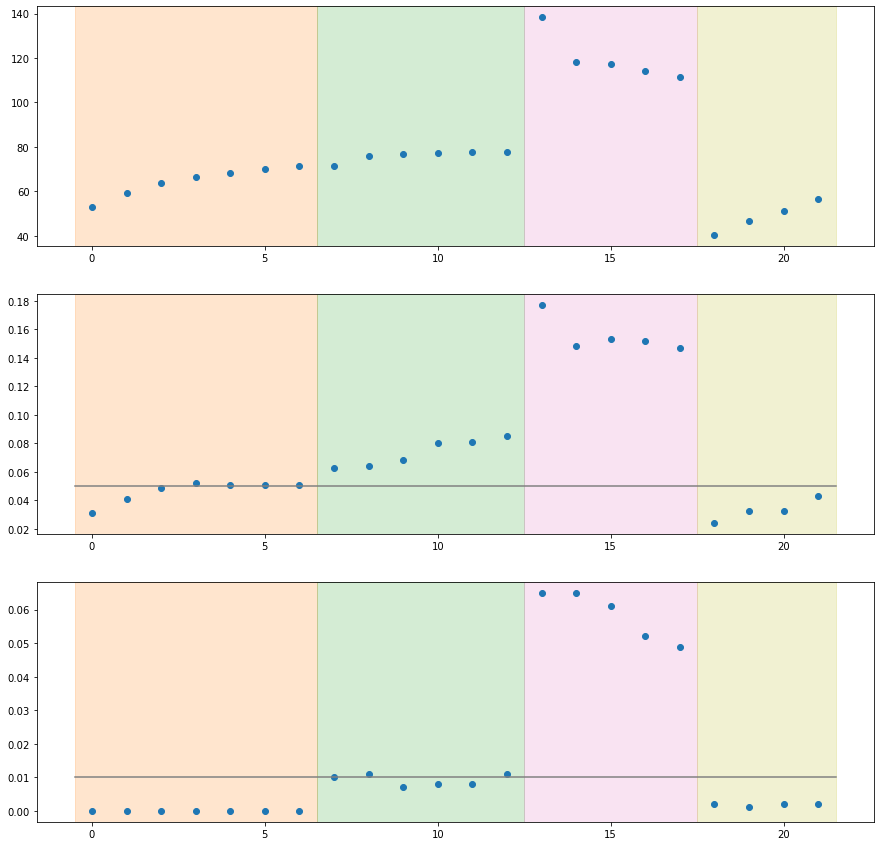

In [69]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [70]:
river = 'Salmon_Sayward'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  669.  669.  669.  669.] [ 32.93955956  33.84867245  34.85480018  35.43981165  36.10813834
  36.6203459   37.1859079   59.05520516  55.23181867  50.85419288
  49.78971003  48.57318747  47.62600994 127.4679507  103.94852527
  93.01033574  81.10312498  79.81797918  28.21653066  34.75032488
  34.86426895  38.62463603] [0.131      0.149      0.158      0.19       0.194      0.208
 0.217      0.291      0.3        0.299      0.306      0.299
 0.312      0.413      0.385      0.389      0.385      0.419
 0.04783259 0.07324365 0.10014948 0.11360239] [0.         0.         0.         0.         0.         0.
 0.         0.061      0.054      0.055      0.052      0.062
 0.047      0.144      0.14       0.134      0.145      0.14
 0.00149477 0.00597907 0.00298954 0.00149477]


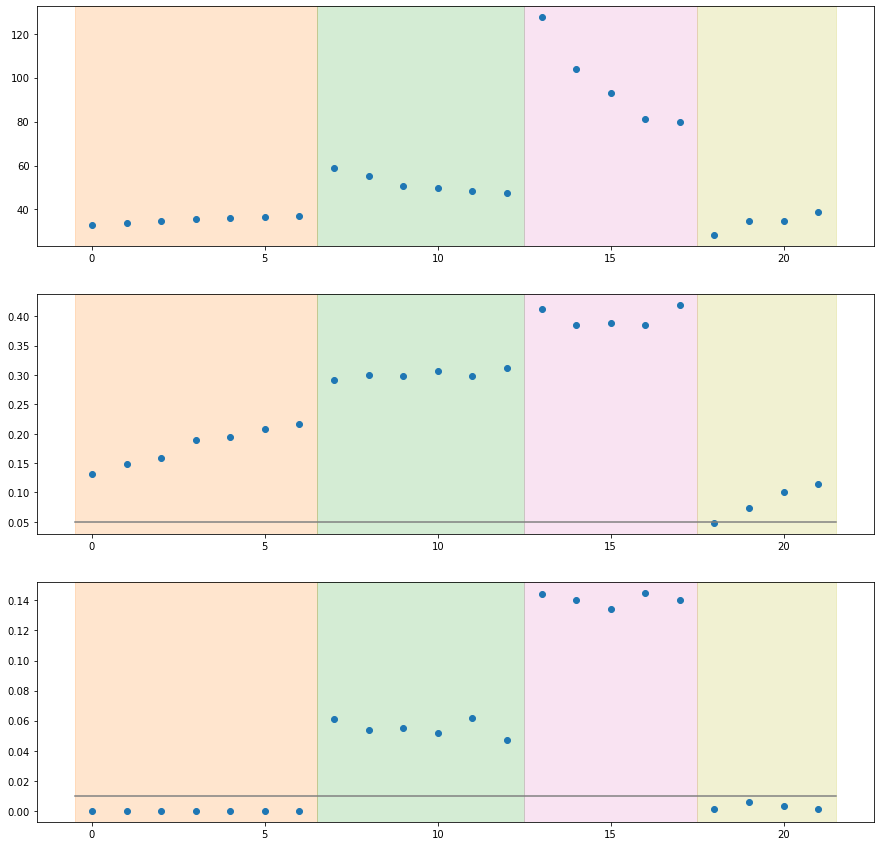

In [71]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [72]:
river = 'RobertsCreek'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0

accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length, accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  676.  676.  676.  676.] [0.60211501 0.61246269 0.62219799 0.62730318 0.62965579 0.64292162
 0.6610068  1.15949126 1.02740665 0.93396603 0.91524347 0.88410697
 0.87252456 2.83701181 2.02045529 1.69491407 1.53841473 1.46450189
 0.34704085 0.3967459  0.43657126 0.47610895] [0.19       0.213      0.224      0.242      0.257      0.275
 0.28       0.398      0.402      0.388      0.391      0.393
 0.4        0.504      0.481      0.491      0.484      0.512
 0.06952663 0.11242604 0.12278107 0.13905325] [0.         0.         0.         0.         0.         0.
 0.         0.107      0.092      0.071      0.087      0.091
 0.102      0.195      0.186      0.165      0.158      0.159
 0.         0.         0.         0.00147929]


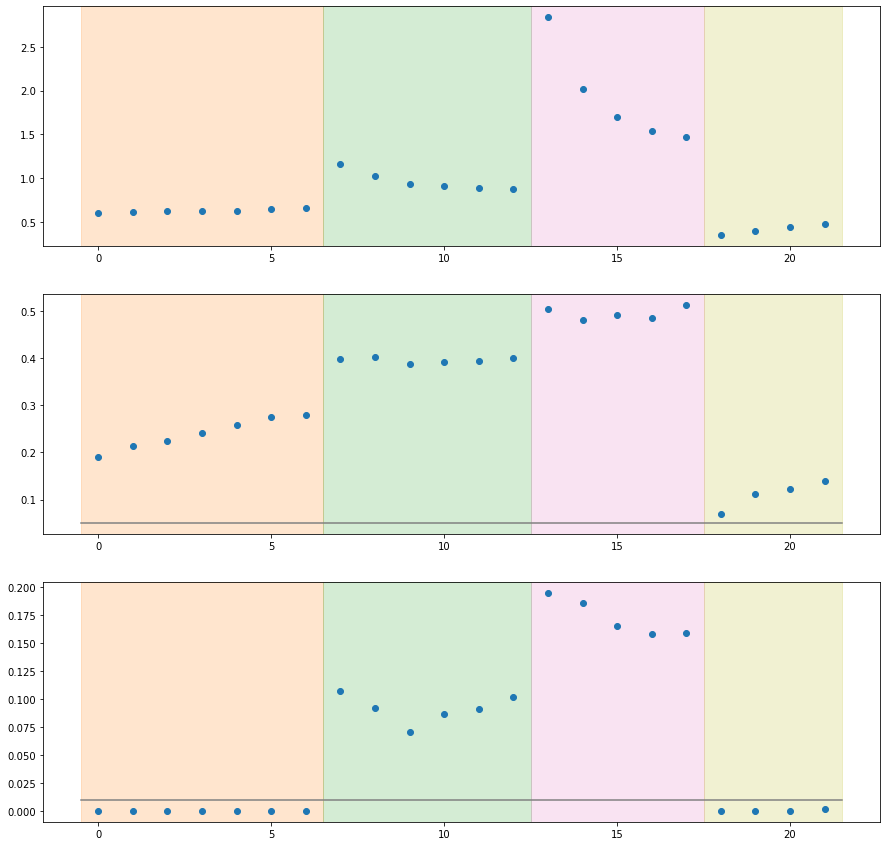

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [77]:
print (gap_length)

2


In [79]:
river = 'Squamish_Brackendale'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  846.  846.  846.  846.] [ 65.36480847  69.20834715  71.35494511  73.03928872  73.94971629
  75.68297899  76.79696872 103.52781959 101.21714733 100.74933765
  98.25816591  98.32317038  95.62804159 197.64241068 182.52842763
 170.32096082 157.16714924 146.63315974  41.42143464  46.43782028
  50.83418892  54.92826366] [0.067      0.076      0.088      0.096      0.104      0.114
 0.128      0.186      0.19       0.197      0.182      0.175
 0.192      0.373      0.332      0.335      0.328      0.306
 0.0212766  0.03664303 0.04137116 0.04728132] [0.    0.    0.    0.    0.    0.    0.    0.027 0.029 0.035 0.032 0.023
 0.022 0.144 0.115 0.108 0.107 0.1   0.    0.    0.    0.   ]


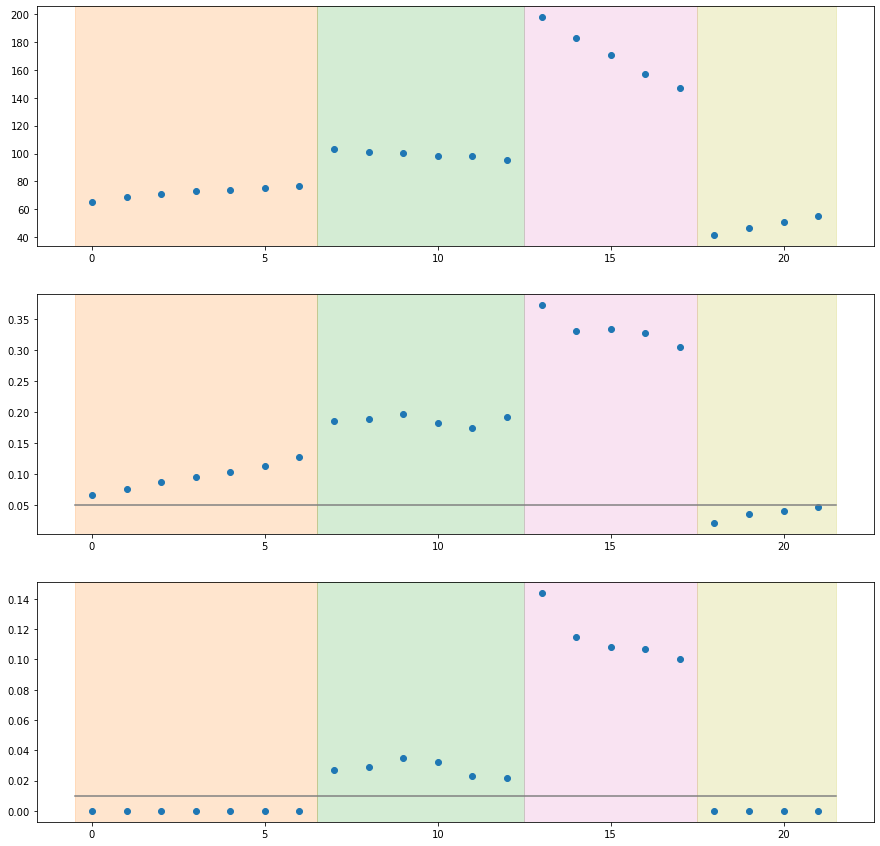

In [80]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [81]:
river = 'SanJuan_PortRenfrew'
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

0 Primary River Flow    16.0
Name: 1959-10-08 00:00:00, dtype: float64
0 Primary River Flow    16.0
Name: 1959-10-08 00:00:00, dtype: float64
0 Primary River Flow    16.0
Name: 1959-10-08 00:00:00, dtype: float64
0 Primary River Flow    16.0
Name: 1959-10-08 00:00:00, dtype: float64
0 Primary River Flow    16.0
Name: 1959-10-08 00:00:00, dtype: float64
0 Primary River Flow    16.0
Name: 1959-10-08 00:00:00, dtype: float64
0 Primary River Flow    16.0
Name: 1959-10-08 00:00:00, dtype: float64
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  708.  708.  708.  708.] [ 30.64642389  31.05719717  30.97894782  31.38086725  31.64257266
  32.06952678  32.61081005  54.09753828  53.17020009  49.12049649
  46.06531824  44.00118269  44.43388931 118.53916462  90.47279266
  88.80009978  82.36485981  74.18981333  17.86640026  18.28907016
  19.83053397  19.94152728] [0.172      0.184      0.21       0.234      0.252      0.271
 0.276      0.

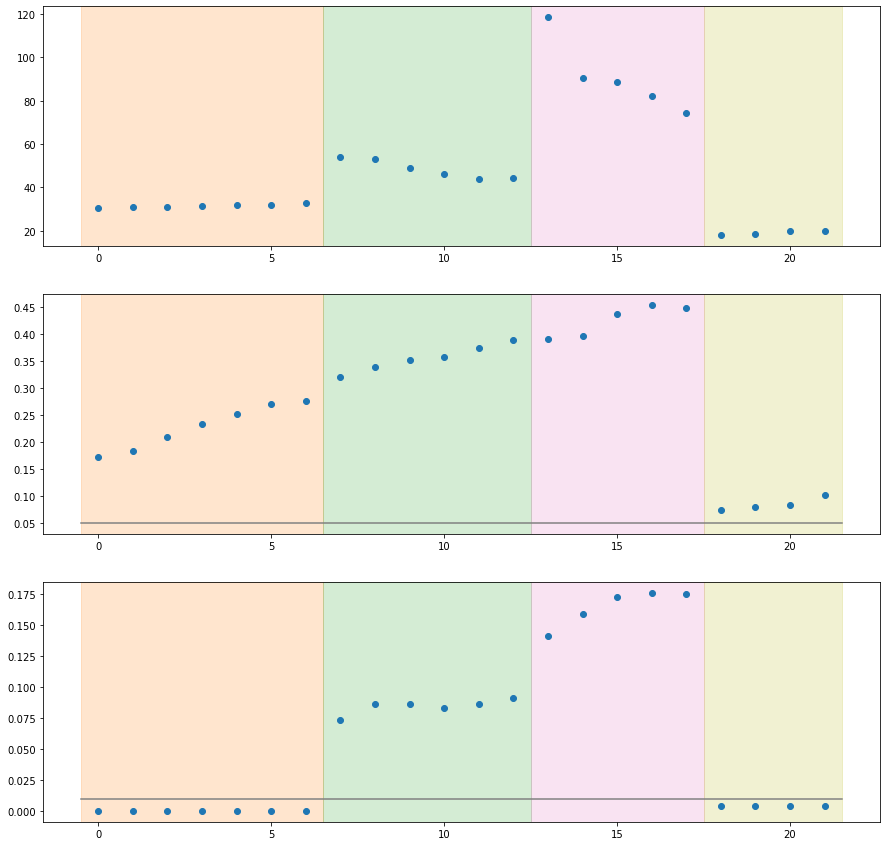

In [82]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [86]:
river = 'SanJuan_PortRenfrew'
# use backup River
primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,
        accumulateG, accumulateC, accumulateB, fittedbad, 'backup', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  984.  984.  984.  984.] [ 31.30845572  30.48267007  30.89231855  31.66142683  32.01172152
  32.28698692  32.77248994  62.18346919  54.08821097  50.21385495
  45.42422848  43.12068091  43.85481966 145.47128315 103.70875825
  91.85930809  82.95716302  73.26067659  19.92107489  20.35347299
  20.48188599  21.12994234] [0.183      0.205      0.232      0.247      0.257      0.267
 0.278      0.329      0.342      0.336      0.371      0.361
 0.376      0.407      0.412      0.421      0.432      0.438
 0.09552846 0.12195122 0.1351626  0.14939024] [0.         0.         0.         0.         0.         0.
 0.         0.086      0.092      0.078      0.071      0.074
 0.08       0.168      0.161      0.151      0.166      0.148
 0.         0.         0.         0.00101626]


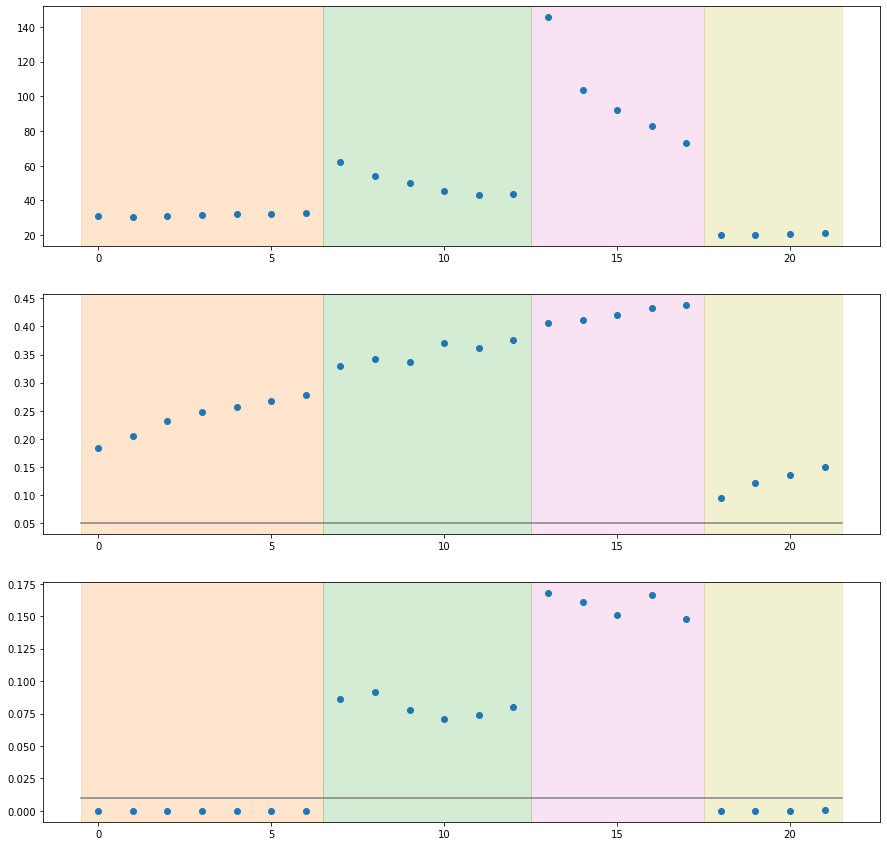

In [87]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [89]:
river = 'Nicomekl_Langley'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  989.  989.  989.  989.] [1.3871998  1.41327028 1.46519683 1.47611164 1.489632   1.51518366
 1.52277693 3.12414406 2.66184179 2.36042068 2.16675434 2.12213632
 2.03623327 7.06119566 5.66973114 4.80782552 4.16722541 3.50370554
 1.2076506  1.20743816 1.20135793 1.2051521 ] [0.247      0.279      0.294      0.315      0.327      0.347
 0.353      0.463      0.467      0.451      0.46       0.455
 0.45       0.546      0.557      0.558      0.556      0.549
 0.15975733 0.18301314 0.20323559 0.20930233] [0.         0.         0.         0.         0.         0.
 0.         0.162      0.136      0.141      0.133      0.122
 0.124      0.212      0.209      0.206      0.22       0.224
 0.00101112 0.         0.         0.        ]


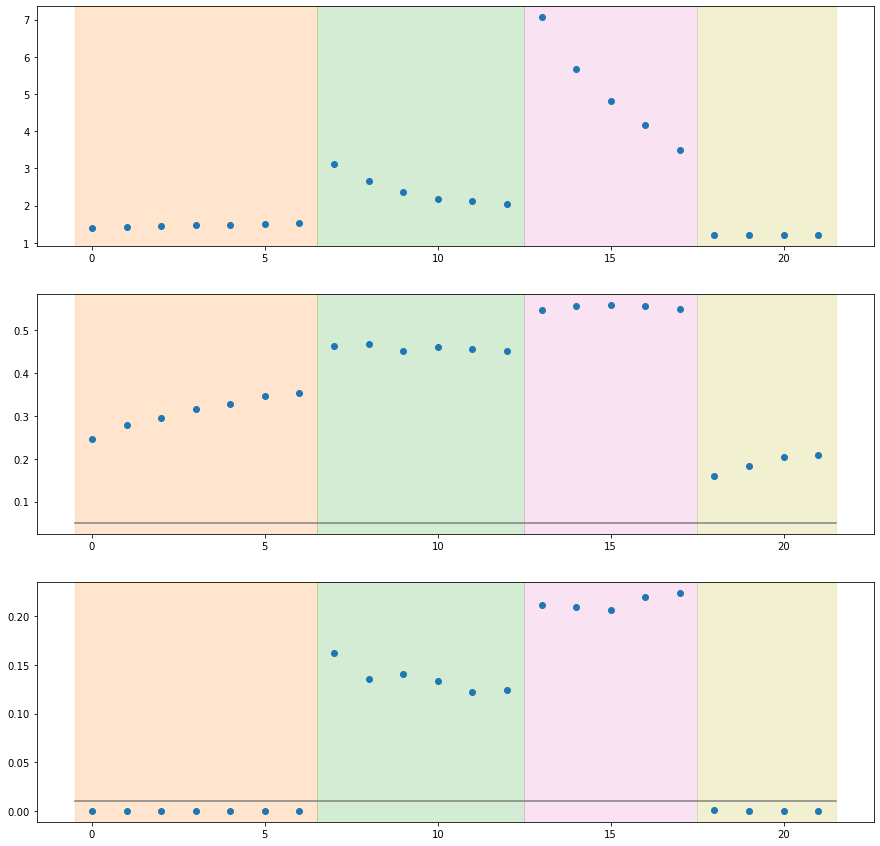

In [90]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [92]:
river = 'Snohomish_Monroe'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [ 76.95866141  84.28584726  90.31942568  94.55613893  97.77838626
  99.78213546 101.38941038 105.44462079 109.77860725 112.41098951
 114.09138769 113.47380244 118.06088253 206.98464085 184.61907129
 166.8911572  168.95314708 166.45958549  50.09335344  57.09933549
  60.11292635  63.30290745] [0.062 0.075 0.077 0.084 0.102 0.107 0.111 0.128 0.14  0.152 0.151 0.139
 0.156 0.236 0.242 0.249 0.245 0.24  0.017 0.018 0.022 0.029] [0.    0.    0.    0.    0.    0.    0.    0.014 0.019 0.024 0.031 0.02
 0.023 0.084 0.083 0.07  0.074 0.076 0.001 0.001 0.001 0.001]


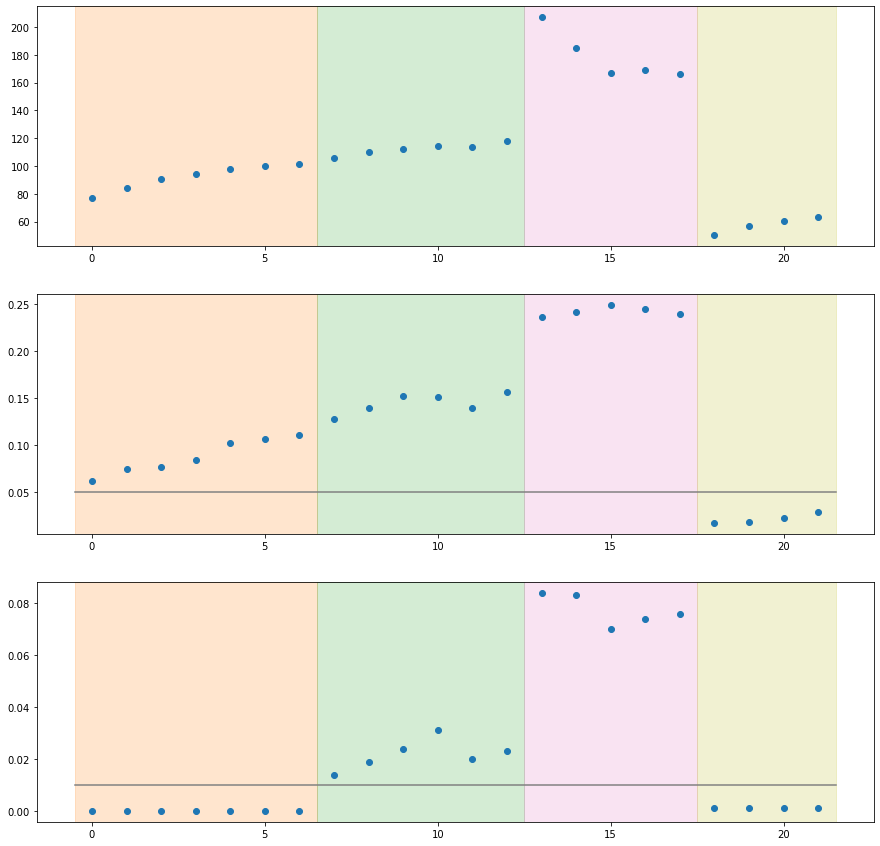

In [93]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [96]:
river = 'Skagit_MountVernon'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  999.  999.  999.  999.] [ 87.2995594   94.00271295  98.02511413  99.5257632   99.53706172
 100.01861673 101.29582519 150.1056474  142.29262545 138.60906839
 137.91991988 139.45179458 138.71375655 316.4614609  266.45130353
 232.78193634 220.6441664  205.79129911  92.34028984 115.47027908
 126.47029158 135.30860911] [0.018      0.022      0.026      0.027      0.026      0.026
 0.029      0.086      0.063      0.064      0.06       0.059
 0.059      0.261      0.215      0.175      0.168      0.155
 0.01701702 0.02602603 0.03103103 0.03603604] [0.       0.       0.       0.       0.       0.       0.       0.018
 0.013    0.01     0.005    0.003    0.006    0.112    0.093    0.077
 0.059    0.061    0.001001 0.       0.       0.      ]


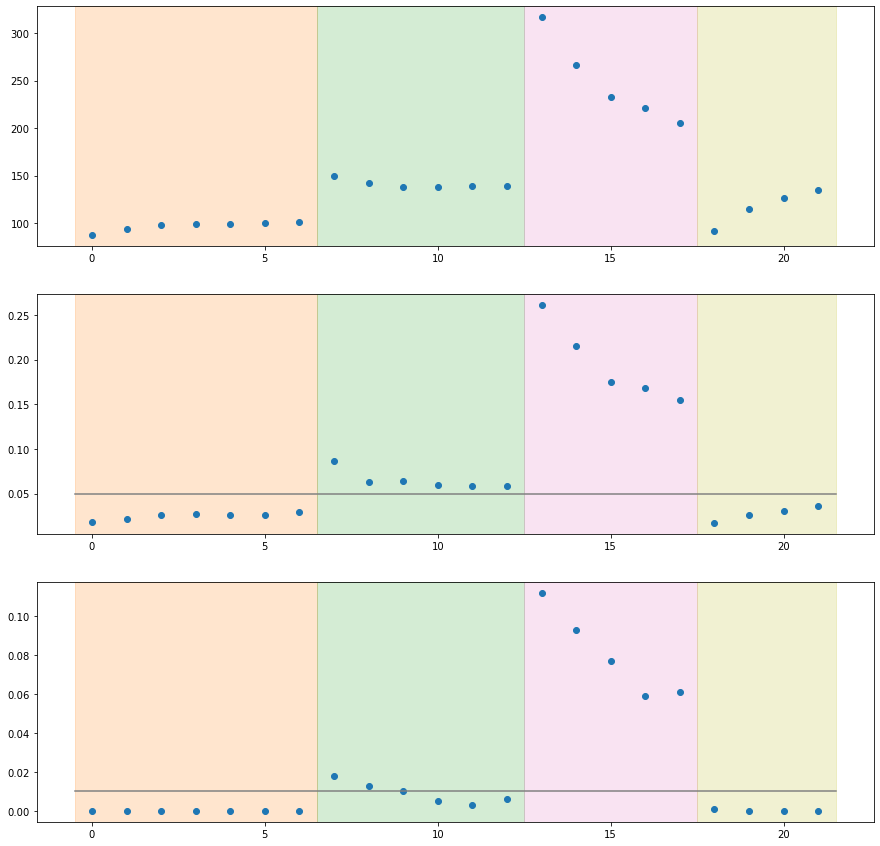

In [97]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [99]:
river = 'Nisqually_McKenna'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  996.  996.  996.  996.] [ 6.92416556  7.8298215   8.51274713  8.83860039  9.16357668  9.52167489
  9.78121725 11.09692867 10.340252   10.41202835 10.78693384 11.1562586
 11.27036851 23.52610859 20.1718481  17.09695775 15.73241651 15.32924921
 10.03752992 12.73864263 14.20901474 15.2762707 ] [0.028      0.026      0.029      0.041      0.043      0.043
 0.047      0.072      0.077      0.064      0.064      0.065
 0.064      0.177      0.164      0.146      0.141      0.126
 0.05321285 0.08634538 0.10240964 0.11746988] [0.    0.    0.    0.    0.    0.    0.    0.011 0.009 0.005 0.006 0.006
 0.008 0.057 0.06  0.048 0.039 0.032 0.    0.    0.    0.   ]


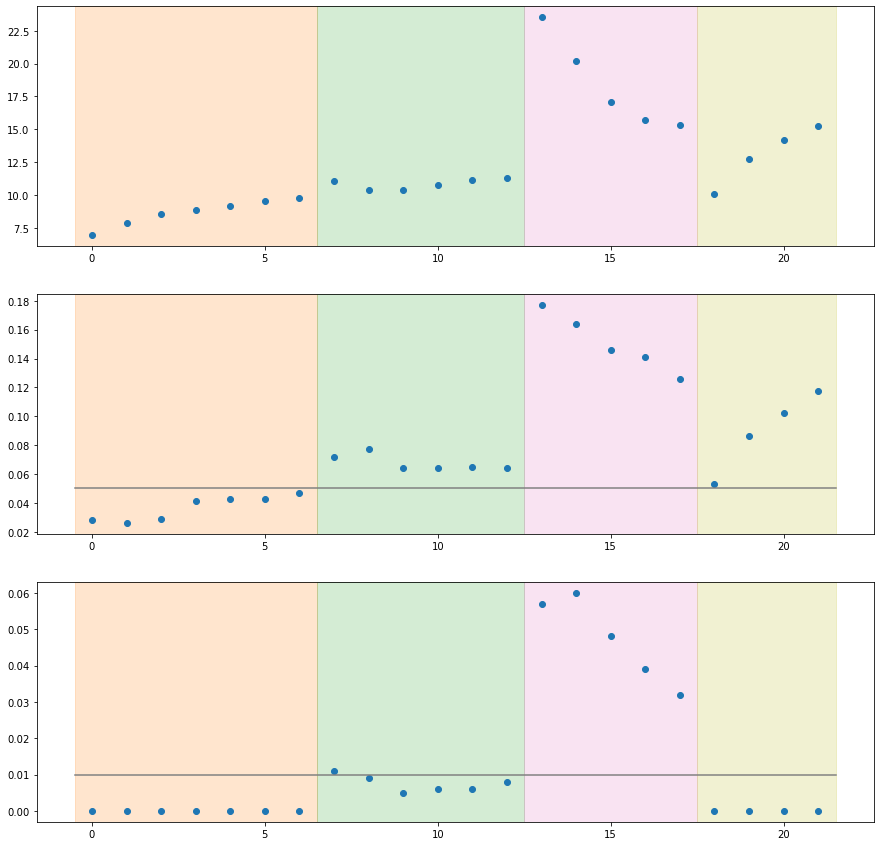

In [100]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [102]:
river = 'Greenwater_Greenwater'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  999.  999.  999.  999.] [1.18241902 1.39338905 1.52552518 1.59012218 1.65753018 1.71954763
 1.76391378 1.45055649 1.56103715 1.79452284 1.92800543 1.97264293
 2.00329452 3.19599748 2.99982302 2.48595676 2.61518165 2.67555187
 0.93229652 1.06678199 1.15084381 1.21270441] [0.024      0.035      0.038      0.045      0.051      0.048
 0.05       0.047      0.061      0.06       0.067      0.076
 0.077      0.107      0.117      0.122      0.114      0.132
 0.01601602 0.02402402 0.03403403 0.03603604] [0.       0.       0.       0.       0.       0.       0.       0.01
 0.009    0.014    0.014    0.011    0.01     0.04     0.05     0.046
 0.052    0.059    0.       0.002002 0.001001 0.      ]


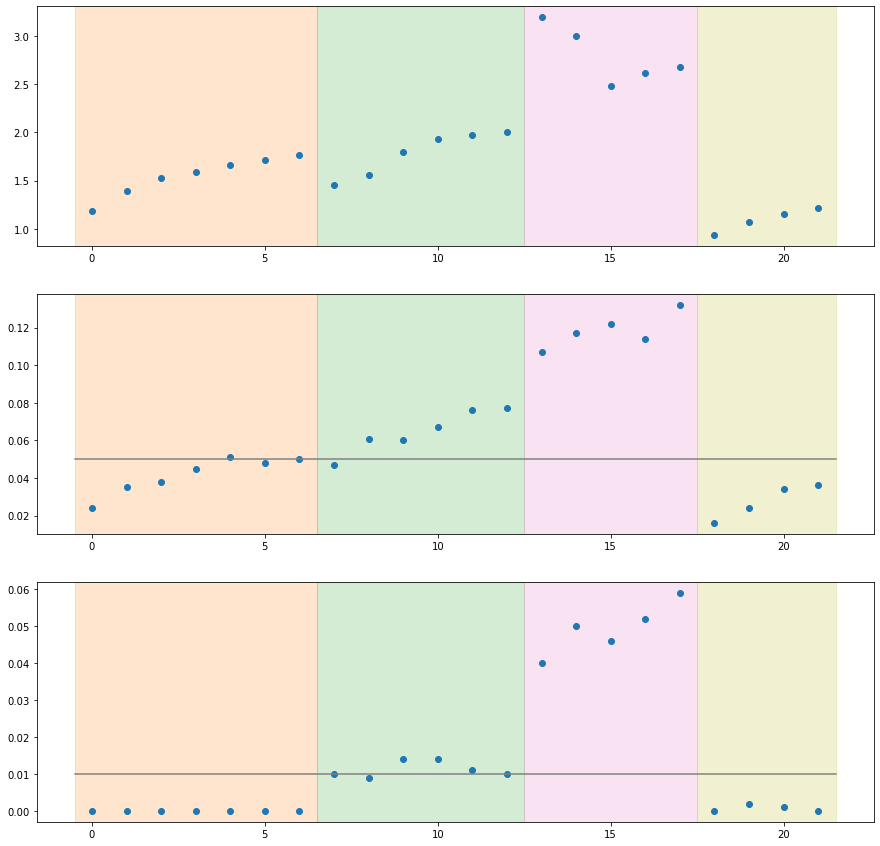

In [103]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [118]:
river = 'Clowhom_ClowhomLake'

primary_river = read_river(river, 'primary')

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  756.  756.  756.  756.] [ 6.33116607  6.60660933  6.72312312  6.76411806  6.87989093  7.02895651
  7.15254944 11.89881627 10.45938517 10.27933004 10.29852805 10.06863361
  9.83972497 26.59513074 20.27535735 17.35153093 16.23623375 15.81733312
  7.72207006  8.72316182  9.27974304 10.07002291] [0.122      0.13       0.144      0.155      0.17       0.174
 0.179      0.282      0.293      0.288      0.296      0.302
 0.3        0.409      0.391      0.395      0.415      0.403
 0.08994709 0.11904762 0.13095238 0.14814815] [0.         0.         0.         0.         0.         0.
 0.         0.062      0.065      0.066      0.065      0.068
 0.07       0.162      0.145      0.145      0.149      0.155
 0.00793651 0.01058201 0.00925926 0.00925926]


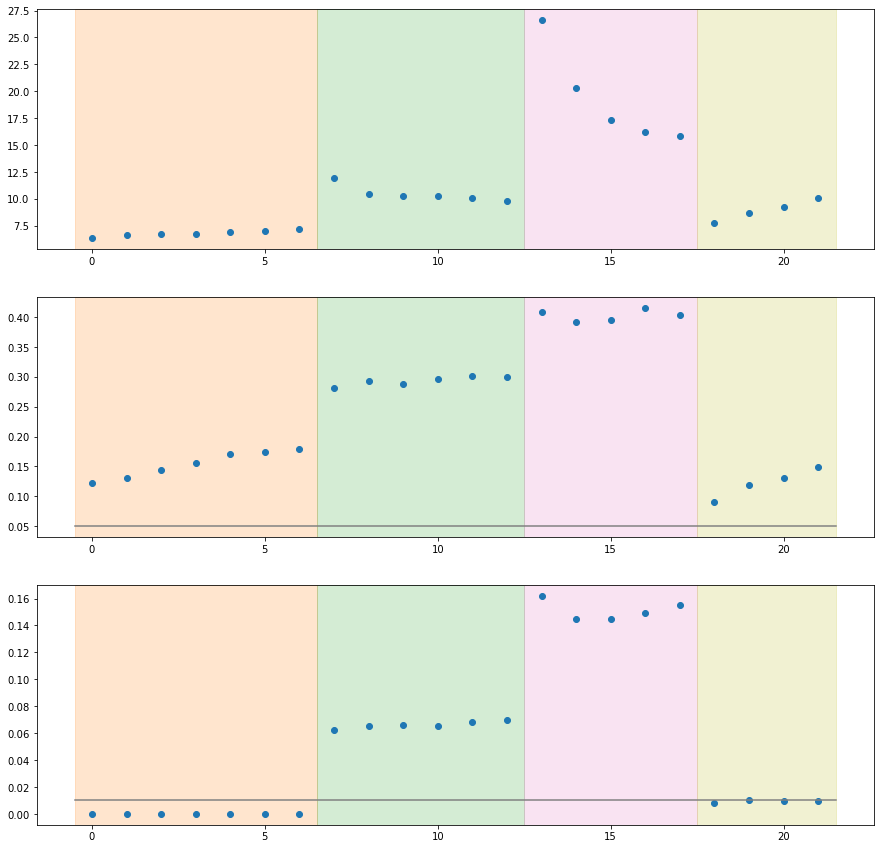

In [119]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [112]:
river = 'Theodosia'

primary_river = read_river_Theodosia(set_primary=True)
primary_river = primary_river.drop(['Diversion_x', 'Bypass', 'Scotty', 'Diversion_y', 
                                   'FlowFromDiversion'], axis=1)

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'fit', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.] [ 5.3354796   5.34842018  5.39173005  5.50058356  5.52833944  5.58595551
  5.66580724  9.88561983  9.05085417  8.17403554  7.68574779  7.57105182
  7.60424613 22.10282098 17.20096959 14.51765995 13.04704935 12.15008384
  2.52951536  2.80256372  2.93057143  3.14498896] [0.238 0.24  0.268 0.277 0.299 0.306 0.335 0.415 0.415 0.45  0.447 0.438
 0.444 0.487 0.501 0.513 0.542 0.544 0.07  0.083 0.095 0.119] [0.    0.    0.    0.    0.    0.    0.    0.104 0.106 0.103 0.105 0.089
 0.101 0.171 0.181 0.178 0.187 0.195 0.    0.    0.    0.   ]


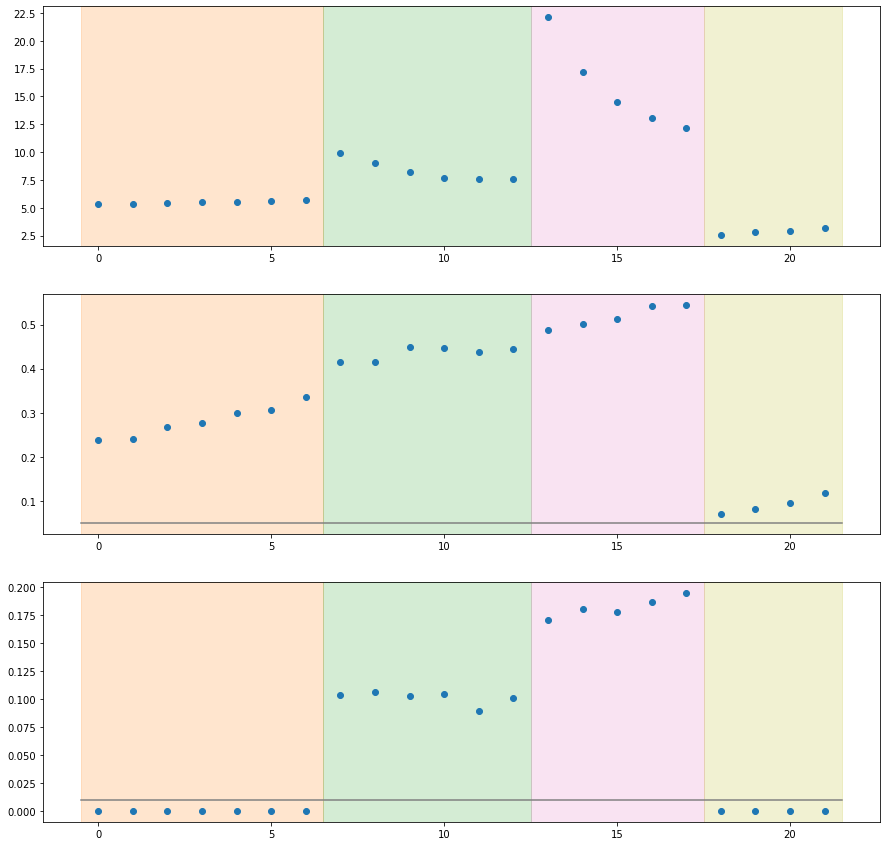

In [113]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');

In [116]:
river = 'Theodosia'

# Try Clowhom Lake *****

primary_river = read_river_Theodosia(set_primary=True)
primary_river = primary_river.drop(['Diversion_x', 'Bypass', 'Scotty', 'Diversion_y', 
                                   'FlowFromDiversion'], axis=1)

number_trys = 1000
fittedbad = 0
accumulateG, accumulateC, accumulateB = np.zeros(22), np.zeros(22),  np.zeros(22)

for ii in range(number_trys):
    accumulateG, accumulateC, accumulateB, fittedbad = doone(
        primary_river, gap_length,accumulateG, accumulateC, accumulateB, fittedbad, 'backup', doplots=False)

number_good = number_trys * np.ones(22)

for ii in [18, 19, 20, 21]:
    number_good[ii] = number_trys - fittedbad
    
print (number_good, accumulateG/number_good, accumulateC/number_good, accumulateB/number_good)

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.  970.  970.  970.  970.] [ 5.1956782   5.16277047  5.21041223  5.1168582   5.12285305  5.15830761
  5.24002571 10.12005976  9.4176017   8.24424121  7.94105055  7.76210473
  7.65897963 22.59987838 18.4717187  15.71279391 13.3293118  12.71761892
  3.68638352  4.28817929  4.478806    4.72783293] [0.221      0.24       0.244      0.269      0.284      0.289
 0.297      0.411      0.418      0.44       0.429      0.433
 0.44       0.527      0.513      0.547      0.546      0.531
 0.14020619 0.16597938 0.18247423 0.24329897] [0.         0.         0.         0.         0.         0.
 0.         0.109      0.101      0.095      0.102      0.099
 0.105      0.181      0.184      0.187      0.175      0.178
 0.         0.00309278 0.00206186 0.00206186]


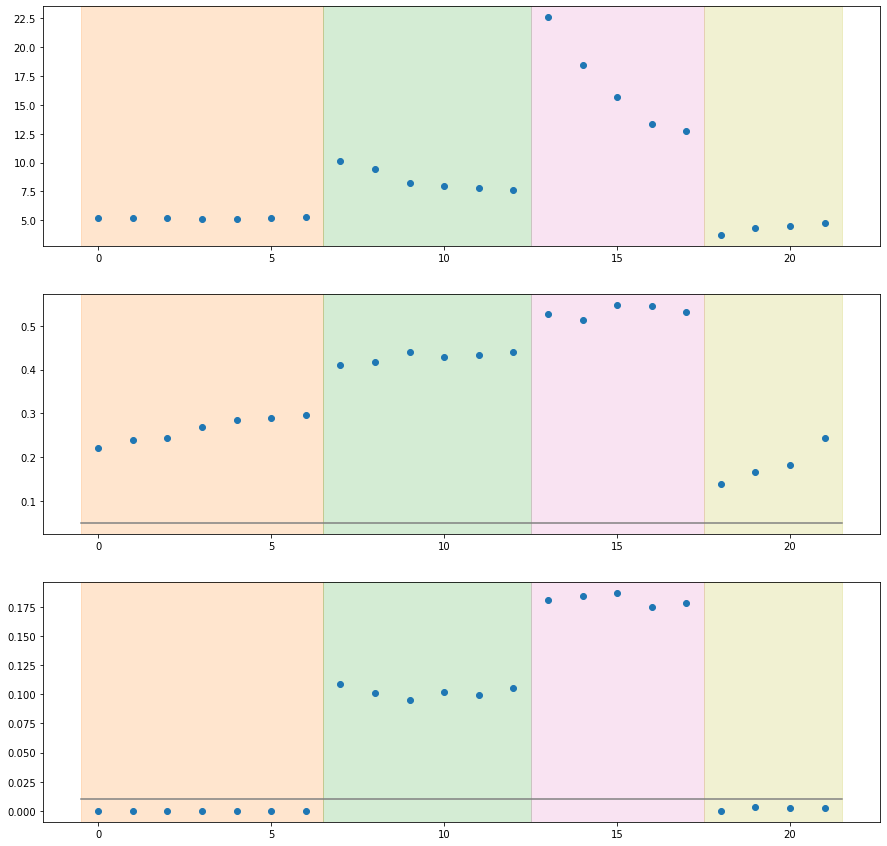

In [117]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
axs[0].plot(np.abs(accumulateG)/number_good, 'o')
axs[1].plot(np.abs(accumulateC)/number_good, 'o')
axs[2].plot(np.abs(accumulateB)/number_good, 'o')

for ax in axs:
    ax.axvspan(-0.5, 6.5, color='tab:orange', alpha=0.2) 
    ax.axvspan(6.5, 12.5, color='tab:green', alpha=0.2) 
    ax.axvspan(12.5, 17.5, color='tab:pink', alpha=0.2)
    ax.axvspan(17.5, 21.5, color='tab:olive', alpha=0.2)
    
axs[1].plot([-0.5, 21.5], [0.05, 0.05], c='grey')
axs[2].plot([-0.5, 21.5], [0.01, 0.01], c='grey');